## FUNCTION
### Given Path and value name, we get the summary of all the stations

In [1]:
def read_ecad_sum(path, VAL):
    import pandas as pd
    import numpy as np
    ecad = pd.read_csv(path, names = ['STAID', 'SOUID', 'DATE', VAL, 'QUALITY'], skiprows = 21, parse_dates = ['DATE']).set_index('DATE')
    ecad = ecad[ecad['QUALITY'] == 0]
    output = pd.DataFrame()
    if ecad[VAL].count() >= 365 * 20 and ecad.index.max() >= pd.to_datetime('01/01/2000') and ecad.index.min() < pd.to_datetime('01/01/2000'):
        output['Monthly'] = ecad[VAL].resample(rule = 'M').sum()
        output['Month'] = output.index.month
        months = np.arange(12)
        for i in range(0, 12, 1):
            months[i] = output[output["Month"] == i + 1].mean().drop(['Month'])
        station = ecad['STAID'].mean()
        result = pd.DataFrame(data = months, index = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], columns = [station]).T
    else:
        result = np.zeros(12)
        station = np.zeros(1)
    return result, station

def read_ecad_mean(path, VAL):
    import pandas as pd
    import numpy as np
    ecad = pd.read_csv(path, names = ['STAID', 'SOUID', 'DATE', VAL, 'QUALITY'], skiprows = 21, parse_dates = ['DATE']).set_index('DATE')
    ecad = ecad[ecad[VAL] != -9999]
    if VAL == 'RS':
        ecad = ecad[ecad[VAL] <= 500]
    output = pd.DataFrame()
    if ecad[VAL].count() >= 365 * 20 and ecad.index.max() >= pd.to_datetime('01/01/2000') and ecad.index.min() < pd.to_datetime('01/01/2000'):
        output['Monthly'] = ecad[VAL].resample(rule = 'M').mean()
        output['Month'] = output.index.month
        months = np.arange(12)
        for i in range(0, 12, 1):
            months[i] = output[output["Month"] == i + 1].mean().drop(['Month'])
        station = ecad['STAID'].mean()
        result = pd.DataFrame(data = months, index = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], columns = [station]).T
    else:
        result = np.zeros(12)
        station = np.zeros(1)
    return result, station

def PM(m, Tmean, Tmax, Tmin, RH, U, RS, phi, h):
    import numpy as np
    julian = {'jan': 16, 'feb' : 44, 'mar' : 75, 'apr' : 105, 'may' : 136, 'jun': 166, 'jul' : 197, 'aug' : 228, 'sep' : 258, 'oct' : 289, 'nov': 319, 'dec': 350}    
    U2 = U * 0.1
    Tmean = Tmean * 0.1
    Tmin = Tmin * 0.1
    Tmax = Tmax * 0.1
    es1 = 0.6108 * np.exp((17.27 * Tmax)/(Tmax + 237.3))
    es2 = 0.6108 * np.exp((17.27 * Tmin)/(Tmin + 237.3))
    es = (es1 + es2) / 2
    ea = RH * es/100
    Delta = 4099 * (0.6108 * np.exp((17.27 * Tmean) / (Tmean + 237.3)) / ((Tmean + 237.3)**2))
    gamma = 0.665 * 0.001 * 1013 / 10
    dr = 1 + 0.033 * np.cos(2 * np.pi * julian[m] / 365)
    d = 0.4093 * np.sin((2 * np.pi * julian[m] / 365) - 1.39)
    omega_s = np.arccos(-1 * np.tan(phi) * np.tan(d))
    Ra = (24 * 60 * 0.082 * dr / np.pi) * (omega_s * np.sin(phi) * np.sin(d) + np.cos(phi) * np.cos(d) * np.sin(omega_s))
    Rso = (0.75 + 2 * 0.00001 * h) * Ra
    Rs = 0.0864 * RS
    Rns = 0.77 * Rs
    Rnl = 4.903 * 0.000000001 * (((273.16 + Tmax)**4 + (273.16 + Tmin)**4) / 2) * (0.34 - 0.14 * np.sqrt(ea)) * (1.35 * (Rs/Rso) - 0.35)
    Rn = Rns - Rnl
    ETo = (0.408 * Delta * (Rn - 0)+(900 * gamma * U2 * (es - ea) / (273 + Tmean))) / (Delta + gamma * (1 + 0.34 * U2))
    return ETo

def TW(T, phi, C = 1):
    days = pd.DataFrame(data = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], index = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], columns = ['n'])
    days['julian'] = [16, 44, 75, 105, 136, 166, 197, 228, 258, 289, 319, 350]
    Tmean = T.ravel() * 0.1
    j = np.zeros(len(Tmean))
    d = np.zeros(len(Tmean))
    omega_s = np.zeros(len(Tmean))
    N = np.zeros(len(Tmean))
    Ep = np.zeros(len(Tmean))

    for i in range(len(Tmean)):
        d[i] = 0.4093 * np.sin((2 * np.pi * days['julian'][i] / 365) - 1.39)
        omega_s[i] = np.arccos(-1 * np.tan(phi) * np.tan(d[i]))
        N[i] = 24 * omega_s[i] / np.pi

    for i in range(len(Tmean)):
        if Tmean[i] < 0 :
            j[i] = 0
        else:
            j[i] = (Tmean[i] / 5) ** 1.514

    J = j.sum()
    a = (6.75 * 10 ** -7) * J ** 3 - (7.71 * 10 ** -5) * J ** 2 + (1.79 * 10 ** -2) * J + 0.492

    for i in range(len(Tmean)):
        if Tmean[i] < 0 :
            Ep[i] = 0            
        else:
            Ep[i] = (16 * (10 * Tmean[i] / J) ** a) * (days['n'][i] * N[i] / (12 * 30))
            Ep[i] = Ep[i] / days['n'][i] * C

    thrn = pd.DataFrame(Ep, index = days['n'], columns = ['Ep Thornthwaite'])
    return thrn

def data_dates(path, VAL):
    import pandas as pd
    import numpy as np
    ecad = pd.read_csv(path, names = ['STAID', 'SOUID', 'DATE', VAL, 'QUALITY'], skiprows = 21, parse_dates = ['DATE']).set_index('DATE')
    ecad = ecad[ecad['QUALITY'] == 0]
    station = ecad['STAID'].mean()
    return ecad.index.min(), ecad.index.max(), station

# Run of function

## Precipitation

In [2]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r'C:\Users\owner\Videos\ECA_blend_rr')

path = os.path.join(r"C:\Users\owner\Videos", "ECA_blend_rr")
path = path + "\\"

precipitation = np.zeros((len(entries), 12))
station = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    precipitation[i], station[i] = read_ecad_sum(path + entries[i], 'p')

prec = pd.DataFrame(data = precipitation, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station.ravel())
prec.index.rename('Station ID', inplace = True)
prec['sum'] = prec.sum(axis = 1)
prec = prec[(prec.T != 0).any()]
prec

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,sum
Station ID,,,,,,,,,,,,,
1.0,436.0,336.0,332.0,348.0,433.0,558.0,698.0,738.0,595.0,576.0,537.0,502.0,6089.0
2.0,347.0,256.0,260.0,314.0,461.0,584.0,738.0,797.0,566.0,497.0,437.0,378.0,5635.0
3.0,281.0,204.0,225.0,234.0,332.0,540.0,785.0,742.0,494.0,415.0,345.0,310.0,4907.0
4.0,329.0,266.0,266.0,324.0,383.0,511.0,708.0,673.0,507.0,449.0,424.0,373.0,5213.0
5.0,314.0,260.0,259.0,321.0,385.0,515.0,698.0,671.0,510.0,448.0,415.0,362.0,5158.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20824.0,725.0,516.0,541.0,515.0,578.0,620.0,776.0,965.0,948.0,1083.0,1042.0,837.0,9146.0
20825.0,726.0,526.0,535.0,529.0,605.0,635.0,788.0,981.0,962.0,1116.0,1074.0,848.0,9325.0
21755.0,321.0,225.0,230.0,264.0,421.0,607.0,753.0,766.0,590.0,505.0,414.0,362.0,5458.0


## Wind Speed

In [3]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_fg")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_fg")
path = path + "\\"

ws = np.zeros((len(entries), 12))
station_ws = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    ws[i], station_ws[i] = read_ecad_mean(path + entries[i], 'U')

wind = pd.DataFrame(data = ws, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_ws.ravel())
wind.index.rename('Station ID', inplace = True)
wind['mean'] = wind.mean(axis = 1)
wind = wind[(wind.T != 0).any()]
wind

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
5.0,41.0,40.0,40.0,38.0,36.0,36.0,34.0,33.0,38.0,38.0,38.0,40.0,37.666667
7.0,31.0,31.0,32.0,29.0,29.0,28.0,26.0,26.0,29.0,30.0,31.0,30.0,29.333333
32.0,15.0,15.0,15.0,15.0,13.0,13.0,13.0,12.0,12.0,13.0,13.0,16.0,13.750000
33.0,35.0,40.0,42.0,41.0,37.0,34.0,34.0,32.0,31.0,33.0,33.0,35.0,35.583333
34.0,20.0,21.0,22.0,24.0,22.0,21.0,21.0,18.0,16.0,17.0,18.0,20.0,20.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19687.0,28.0,27.0,27.0,25.0,24.0,23.0,19.0,17.0,19.0,23.0,24.0,26.0,23.500000
20045.0,53.0,50.0,52.0,43.0,41.0,38.0,34.0,33.0,45.0,46.0,51.0,51.0,44.750000
20046.0,56.0,53.0,52.0,48.0,48.0,49.0,47.0,47.0,53.0,56.0,57.0,56.0,51.833333


## Relative Humidity

In [4]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_hu")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_hu")
path = path + "\\"

RelH = np.zeros((len(entries), 12))
station_RH = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    RelH[i], station_RH[i] = read_ecad_mean(path + entries[i], 'RH')

RH = pd.DataFrame(data = RelH, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_RH.ravel())
RH['mean'] = RH.mean(axis = 1)
RH = RH[(RH.T != 0).any()]
RH

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
15.0,75.0,76.0,82.0,87.0,90.0,90.0,90.0,89.0,86.0,79.0,79.0,77.0,83.333333
16.0,78.0,74.0,69.0,63.0,65.0,65.0,64.0,67.0,72.0,77.0,80.0,81.0,71.250000
21.0,80.0,74.0,67.0,64.0,66.0,67.0,65.0,67.0,72.0,77.0,80.0,82.0,71.750000
22.0,67.0,65.0,59.0,49.0,45.0,40.0,36.0,36.0,41.0,50.0,58.0,65.0,50.916667
23.0,72.0,70.0,68.0,65.0,63.0,63.0,66.0,65.0,61.0,60.0,65.0,71.0,65.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19157.0,80.0,78.0,74.0,73.0,72.0,75.0,77.0,79.0,82.0,81.0,80.0,80.0,77.583333
19167.0,78.0,76.0,71.0,70.0,70.0,74.0,76.0,77.0,79.0,78.0,79.0,80.0,75.666667
19192.0,79.0,78.0,74.0,72.0,70.0,72.0,77.0,80.0,81.0,80.0,80.0,79.0,76.833333
20062.0,88.0,84.0,79.0,73.0,72.0,71.0,75.0,78.0,83.0,87.0,89.0,88.0,80.583333


## Radiation

In [5]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_qq")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_qq")
path = path + "\\"

RS_ = np.zeros((len(entries), 12))
station_RS = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    RS_[i], station_RS[i] = read_ecad_mean(path + entries[i], 'RS')

RS = pd.DataFrame(data = RS_, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_RS.ravel())
RS.index.rename('Station ID', inplace = True)
RS['mean'] = RS.mean(axis = 1)
RS = RS[(RS.T != 0).any()]
RS

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
12.0,45.0,77.0,123.0,167.0,210.0,224.0,222.0,193.0,142.0,92.0,50.0,37.0,131.833333
13.0,56.0,91.0,139.0,186.0,219.0,227.0,225.0,197.0,154.0,106.0,60.0,45.0,142.083333
14.0,43.0,72.0,114.0,162.0,199.0,206.0,209.0,182.0,134.0,88.0,46.0,34.0,124.083333
15.0,72.0,111.0,169.0,219.0,252.0,242.0,226.0,192.0,163.0,125.0,78.0,61.0,159.166667
16.0,36.0,66.0,114.0,172.0,224.0,236.0,235.0,203.0,144.0,84.0,40.0,28.0,131.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18020.0,0.0,12.0,55.0,125.0,164.0,188.0,161.0,118.0,69.0,19.0,1.0,0.0,76.000000
18049.0,8.0,30.0,69.0,130.0,182.0,197.0,175.0,136.0,80.0,38.0,13.0,5.0,88.583333
18059.0,6.0,25.0,73.0,139.0,189.0,182.0,177.0,135.0,81.0,36.0,9.0,2.0,87.833333


## Mean temperature

In [6]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_tg")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_tg")
path = path + "\\"

Tm = np.zeros((len(entries), 12))
station_T = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    Tm[i], station_T[i] = read_ecad_mean(path + entries[i], 'Tmean')
    
T = pd.DataFrame(data = Tm, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_T.ravel())
T.index.rename('Station ID', inplace = True)
T['mean'] = T.mean(axis = 1)
T = T[(T.T != 0).any()]
T

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
1.0,-23.0,-23.0,1.0,48.0,105.0,145.0,163.0,151.0,113.0,67.0,24.0,-6.0,63.750000
2.0,-60.0,-55.0,-19.0,34.0,95.0,144.0,166.0,147.0,101.0,48.0,-2.0,-43.0,46.333333
3.0,-119.0,-110.0,-65.0,-4.0,57.0,113.0,139.0,117.0,68.0,9.0,-53.0,-101.0,4.250000
4.0,-23.0,-25.0,1.0,49.0,105.0,150.0,171.0,157.0,117.0,67.0,21.0,-9.0,65.083333
5.0,-24.0,-26.0,0.0,47.0,103.0,148.0,169.0,156.0,115.0,66.0,21.0,-10.0,63.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20824.0,-34.0,-28.0,3.0,50.0,102.0,149.0,161.0,146.0,118.0,74.0,21.0,-13.0,62.416667
20825.0,-37.0,-33.0,0.0,48.0,102.0,147.0,160.0,148.0,113.0,69.0,14.0,-21.0,59.166667
21766.0,-46.0,-46.0,-7.0,39.0,100.0,138.0,157.0,146.0,99.0,53.0,3.0,-35.0,50.083333


## Minimum temperature

In [7]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_tn")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_tn")
path = path + "\\"

Tminimum = np.zeros((len(entries), 12))
station_Tmin = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    Tminimum[i], station_Tmin[i] = read_ecad_mean(path + entries[i], 'Tmin')
    
Tmin = pd.DataFrame(data = Tminimum, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_Tmin.ravel())
Tmin.index.rename('Station ID', inplace = True)
Tmin['mean'] = Tmin.mean(axis = 1)
Tmin = Tmin[(Tmin.T != 0).any()]
Tmin

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
1.0,-51.0,-54.0,-34.0,3.0,49.0,89.0,112.0,106.0,73.0,36.0,0.0,-30.0,24.916667
2.0,-100.0,-98.0,-63.0,-15.0,37.0,85.0,111.0,98.0,58.0,14.0,-30.0,-74.0,1.916667
3.0,-167.0,-163.0,-123.0,-56.0,2.0,55.0,84.0,67.0,26.0,-23.0,-86.0,-140.0,-43.666667
4.0,-52.0,-56.0,-34.0,4.0,51.0,96.0,120.0,112.0,76.0,36.0,-2.0,-34.0,26.416667
5.0,-53.0,-57.0,-36.0,2.0,49.0,93.0,117.0,109.0,74.0,35.0,-3.0,-35.0,24.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20320.0,-55.0,-53.0,-33.0,5.0,43.0,78.0,105.0,99.0,68.0,25.0,-13.0,-40.0,19.083333
20822.0,-49.0,-53.0,-22.0,16.0,66.0,105.0,126.0,119.0,84.0,44.0,2.0,-35.0,33.583333
20823.0,-56.0,-60.0,-28.0,10.0,61.0,101.0,120.0,111.0,78.0,38.0,-4.0,-44.0,27.250000


## Maximum temperature

In [8]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_tx")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_tx")
path = path + "\\"

Tmaximum = np.zeros((len(entries), 12))
station_Tmax = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    Tmaximum[i], station_Tmax[i] = read_ecad_mean(path + entries[i], 'Tmax')
    
Tmax = pd.DataFrame(data = Tmaximum, columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = station_Tmax.ravel())
Tmax.index.rename('Station ID', inplace = True)
Tmax['mean'] = Tmax.mean(axis = 1)
Tmax = Tmax[(Tmax.T != 0).any()]
Tmax

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,mean
Station ID,,,,,,,,,,,,,
1.0,0.0,6.0,39.0,96.0,159.0,198.0,214.0,200.0,157.0,100.0,46.0,14.0,102.416667
2.0,-26.0,-13.0,32.0,87.0,154.0,198.0,219.0,199.0,147.0,84.0,24.0,-10.0,91.250000
3.0,-78.0,-63.0,-13.0,39.0,103.0,159.0,186.0,161.0,107.0,39.0,-22.0,-59.0,46.583333
4.0,0.0,3.0,39.0,99.0,163.0,205.0,224.0,208.0,160.0,100.0,45.0,14.0,105.000000
5.0,0.0,1.0,38.0,97.0,161.0,204.0,223.0,207.0,159.0,99.0,45.0,14.0,104.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20320.0,0.0,5.0,35.0,80.0,128.0,161.0,186.0,178.0,137.0,83.0,37.0,13.0,86.916667
20822.0,3.0,6.0,46.0,97.0,158.0,199.0,215.0,203.0,161.0,104.0,51.0,18.0,105.083333
20823.0,0.0,4.0,46.0,97.0,157.0,198.0,214.0,202.0,160.0,102.0,48.0,14.0,103.500000


## Dates

In [9]:
import os
import pandas as pd
import numpy as np

entries = os.listdir(r"C:\Dimos\database\ECA_blend_qq")

path = os.path.join(r"C:\Dimos\database", "ECA_blend_qq")
path = path + "\\"

dates_min = np.zeros((len(entries), 1), dtype='datetime64[D]')
dates_max = np.zeros((len(entries), 1), dtype='datetime64[D]')
station_name = np.zeros((len(entries), 1))

for i in range(0, len(entries)):
    dates_min[i], dates_max[i], station_name[i] = data_dates(path + entries[i], 'RS')

dates = pd.DataFrame(data = dates_min, columns = ['Oldest'], index = station_name.ravel())
dates['Newest'] = dates_max.ravel()
dates

,Oldest,Newest
11.0,2005-01-01,2020-04-30
12.0,1964-01-01,2020-04-30
13.0,1969-01-01,2020-04-30
14.0,1964-01-01,2020-09-29
15.0,1964-01-01,2020-04-30
...,...,...
18994.0,1971-01-01,2020-09-30
20056.0,2019-09-01,2020-09-30
20059.0,2019-09-01,2020-09-30
20062.0,2019-09-30,2020-09-30


## Export

In [10]:
T.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\T.txt', sep=';', index=True, header=True)
Tmax.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\Tmax.txt', sep=';', index=True, header=True)
Tmin.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\Tmin.txt', sep=';', index=True, header=True)
wind.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\U.txt', sep=';', index=True, header=True)
RH.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\RH.txt', sep=';', index=True, header=True)
RS.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\QQ.txt', sep=';', index=True, header=True)
prec.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\P.txt', sep=';', index=True, header=True)
dates.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\dates.txt', sep=';', index=True, header=True)

# Find mutual stations

In [11]:
hu = RH
qq = RS
tmeann = T
tmaxx = Tmax
tminn = Tmin
windspeed = wind

idx = qq.index.intersection(hu.index)
idx2  = windspeed.index.intersection(tmeann.index)
idx3 = tmaxx.index.intersection(tminn.index)
idx = pd.DataFrame(index = idx)
idx2  = pd.DataFrame(index = idx2)
idx3 = pd.DataFrame(index = idx3)
mutuals = idx.index.intersection(idx2.index)
mutuals = pd.DataFrame(index = mutuals)
mutuals = mutuals.index.intersection(idx3.index)
mutuals = pd.DataFrame(index = mutuals)
tmeann = pd.read_csv(r'C:\Dimos\database\whole data\Tmean.txt', skiprows = 18, names = ['STAID','Station Name', 'CN', 'Lat', 'Lon', 'h']).set_index('STAID')
stations_all = mutuals.merge(tmeann, left_index = True, right_index = True)
phi = np.zeros((len(stations_all['Lat']), 1))
for i in range(len(stations_all['Lat'])):
    phi[i] = (int(stations_all['Lat'].iloc[i][0:3]) + int(stations_all['Lat'].iloc[i][4:6])/60 + int(stations_all['Lat'].iloc[i][7:9])/3600)
stations_all['phi'] = phi * np.pi / 180
stations_all.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\stations.txt', sep=';', index=True, header=True)
stations_all

,Station Name,CN,Lat,Lon,h,phi
32,BOURGES,FR,+47:03:33,+002:21:34,161,0.821337
34,BORDEAUX-MERIGNAC,FR,+44:49:50,-000:41:29,47,0.782441
36,PERPIGNAN,FR,+42:44:13,+002:52:22,42,0.745900
39,MARIGNANE,FR,+43:26:16,+005:12:57,9,0.758132
40,BAMBERG,DE,+49:52:31,+010:55:18,240,0.870488
...,...,...,...,...,...,...
18018,TJOTTA,NO,+65:49:45,+012:25:32,21,1.148936
18020,TROMSO - HOLT,NO,+69:39:14,+018:54:33,20,1.215690
18059,FROSTA,NO,+63:33:55,+010:41:35,32,1.109423
18811,TRONDHEIM - TYHOLT,NO,+63:25:21,+010:25:49,113,1.106931


## Apply Penman Monteith

In [12]:
evap_jan, evap_feb, evap_mar, evap_apr, evap_may, evap_jun, evap_jul, evap_aug, evap_sep, evap_oct, evap_nov, evap_dec = ([] for i in range(12))
for i in stations_all.index:
    evap_jan.append(PM('jan', T.loc[i:i, 'jan'], Tmax.loc[i:i, 'jan'], Tmin.loc[i:i, 'jan'], RH.loc[i:i, 'jan'], wind.loc[i:i, 'jan'], RS.loc[i:i, 'jan'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_feb.append(PM('feb', T.loc[i:i, 'feb'], Tmax.loc[i:i, 'feb'], Tmin.loc[i:i, 'feb'], RH.loc[i:i, 'feb'], wind.loc[i:i, 'feb'], RS.loc[i:i, 'feb'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_mar.append(PM('mar', T.loc[i:i, 'mar'], Tmax.loc[i:i, 'mar'], Tmin.loc[i:i, 'mar'], RH.loc[i:i, 'mar'], wind.loc[i:i, 'mar'], RS.loc[i:i, 'mar'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_apr.append(PM('apr', T.loc[i:i, 'apr'], Tmax.loc[i:i, 'apr'], Tmin.loc[i:i, 'apr'], RH.loc[i:i, 'apr'], wind.loc[i:i, 'apr'], RS.loc[i:i, 'apr'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_may.append(PM('may', T.loc[i:i, 'may'], Tmax.loc[i:i, 'may'], Tmin.loc[i:i, 'may'], RH.loc[i:i, 'may'], wind.loc[i:i, 'may'], RS.loc[i:i, 'may'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_jun.append(PM('jun', T.loc[i:i, 'jun'], Tmax.loc[i:i, 'jun'], Tmin.loc[i:i, 'jun'], RH.loc[i:i, 'jun'], wind.loc[i:i, 'jun'], RS.loc[i:i, 'jun'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_jul.append(PM('jul', T.loc[i:i, 'jul'], Tmax.loc[i:i, 'jul'], Tmin.loc[i:i, 'jul'], RH.loc[i:i, 'jul'], wind.loc[i:i, 'jul'], RS.loc[i:i, 'jul'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_aug.append(PM('aug', T.loc[i:i, 'aug'], Tmax.loc[i:i, 'aug'], Tmin.loc[i:i, 'aug'], RH.loc[i:i, 'aug'], wind.loc[i:i, 'aug'], RS.loc[i:i, 'aug'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_sep.append(PM('sep', T.loc[i:i, 'sep'], Tmax.loc[i:i, 'sep'], Tmin.loc[i:i, 'sep'], RH.loc[i:i, 'sep'], wind.loc[i:i, 'sep'], RS.loc[i:i, 'sep'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_oct.append(PM('oct', T.loc[i:i, 'oct'], Tmax.loc[i:i, 'oct'], Tmin.loc[i:i, 'oct'], RH.loc[i:i, 'oct'], wind.loc[i:i, 'oct'], RS.loc[i:i, 'oct'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_nov.append(PM('nov', T.loc[i:i, 'nov'], Tmax.loc[i:i, 'nov'], Tmin.loc[i:i, 'nov'], RH.loc[i:i, 'nov'], wind.loc[i:i, 'nov'], RS.loc[i:i, 'nov'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)
    evap_dec.append(PM('dec', T.loc[i:i, 'dec'], Tmax.loc[i:i, 'dec'], Tmin.loc[i:i, 'dec'], RH.loc[i:i, 'dec'], wind.loc[i:i, 'dec'], RS.loc[i:i, 'dec'], stations_all.loc[i:i, 'phi'], stations_all.loc[i:i, 'h']).values)

C:\Users\owner\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
evap = pd.DataFrame(evap_jan, columns = ['Jan'], index = [stations_all.index])
evap['Feb'] = np.array(evap_feb).ravel()
evap['Mar'] = np.array(evap_mar).ravel()
evap['Apr'] = np.array(evap_apr).ravel()
evap['May'] = np.array(evap_may).ravel()
evap['Jun'] = np.array(evap_jun).ravel()
evap['Jul'] = np.array(evap_jul).ravel()
evap['Aug'] = np.array(evap_aug).ravel()
evap['Sep'] = np.array(evap_sep).ravel()
evap['Oct'] = np.array(evap_oct).ravel()
evap['Nov'] = np.array(evap_nov).ravel()
evap['Dec'] = np.array(evap_dec).ravel()
evap = evap[(evap >= 0).all(1)]
evap.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\PM_ETo.txt', sep=';', index=True, header=True)
evap

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
32,0.407406,0.728925,1.435509,2.263563,3.078502,3.706563,4.000365,3.482214,2.236408,1.099860,0.491428,0.363044
34,0.537963,0.960517,1.736190,2.585667,3.307911,4.049434,4.288689,3.781075,2.582844,1.336645,0.636830,0.443760
36,1.197898,1.700938,2.429149,3.363261,4.104713,5.055706,5.748528,4.768715,3.303391,2.032521,1.327183,1.124907
39,0.907281,1.387228,2.252647,3.264398,4.360837,5.500509,6.170700,5.199405,3.482752,1.962547,1.101652,0.803323
40,0.387557,0.601443,1.216562,2.177121,3.143949,3.624284,3.685045,3.029739,1.861810,0.902700,0.458881,0.346208
...,...,...,...,...,...,...,...,...,...,...,...,...
17902,0.422469,0.785475,1.602904,2.559822,3.446993,4.135575,4.197756,3.541500,2.194214,1.184388,0.592023,0.372327
18017,0.438572,0.495439,0.985350,1.686301,2.629265,2.954506,2.932411,2.313548,1.421656,0.731459,0.442225,0.487560
18059,0.442437,0.531187,0.961831,1.659352,2.627805,2.880339,2.855175,2.252443,1.379214,0.751203,0.507551,0.463622
18811,0.423214,0.442608,0.859538,1.505735,2.436877,2.737418,2.646924,2.112043,1.202525,0.632783,0.472606,0.551036


## APPLY THORNTHWAITE

In [14]:
T2 = T.drop(['mean'], axis = 1)
THORN = []
for i in stations_all.index:
    THORN.append((TW(T2.loc[i:i].values, stations_all.loc[i:i, 'phi']).values).T)
evap_th = pd.DataFrame((np.array(THORN).ravel()).reshape(len(stations_all.index), 12), columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], index = stations_all.index)
evap_th = evap_th[(evap_th >= 0).all(1)]
evap_th.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\TW_ETo.txt', sep=';', index=True, header=True)
evap_th

C:\Users\owner\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
32,0.295579,0.450627,0.966144,1.618881,2.586196,3.516690,3.994774,3.579475,2.585836,1.546262,0.691762,0.347183
34,0.475018,0.628273,1.097501,1.669757,2.598337,3.522864,3.959093,3.637980,2.729958,1.702293,0.848057,0.494186
36,0.526440,0.666605,1.133242,1.732177,2.707367,3.952007,4.720423,4.274910,3.082358,1.878374,0.970814,0.587091
39,0.411967,0.557429,1.052347,1.709275,2.795301,4.002618,4.715315,4.237223,3.041154,1.840882,0.898010,0.460516
40,0.000000,0.066119,0.635797,1.558946,2.750965,3.700539,3.991838,3.445859,2.280849,1.210696,0.442700,0.092019
...,...,...,...,...,...,...,...,...,...,...,...,...
18017,0.000000,0.000000,0.148666,1.175936,2.681504,3.932188,4.237218,3.424041,2.114745,0.955439,0.178456,0.000000
18018,0.000000,0.000000,0.305266,1.170397,2.523727,3.954472,4.270708,3.443010,2.199122,1.068599,0.331092,0.060195
18059,0.000000,0.000000,0.172086,1.195430,2.704546,3.934825,4.239207,3.422500,2.110990,0.965373,0.188090,0.000000
18811,0.000000,0.000000,0.000000,1.068270,2.557843,3.797393,4.232197,3.403087,2.084664,0.911966,0.169527,0.000000


## Plot station network

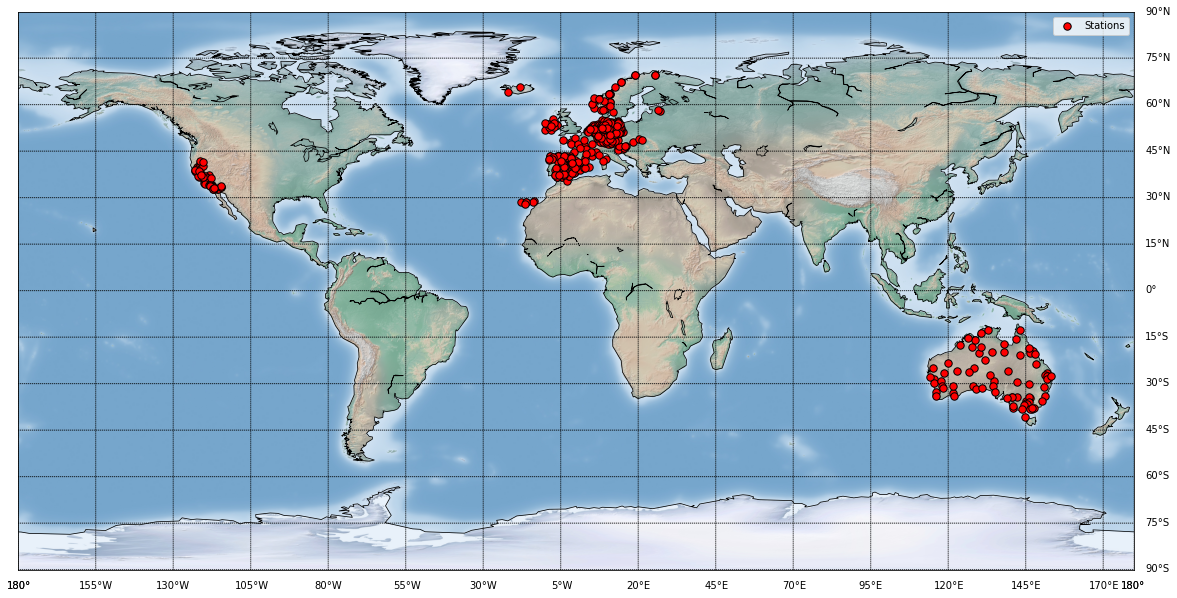

In [2]:
# stations = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\stations.txt", delimiter = ';', index_col = 0)
# phi = np.zeros(len(stations['Lat']))
# labda = np.zeros(len(stations['Lat']))

# for i in range(len(stations)):
#     phi[i] = (int(stations['Lat'].iloc[i][1:3]) + int(stations['Lat'].iloc[i][4:6])/60 + int(stations['Lat'].iloc[i][7:9])/3600)
#     labda[i] = (int(stations['Lon'].iloc[i][1:4]) + int(stations['Lon'].iloc[i][5:7])/60 + int(stations['Lon'].iloc[i][8:10])/3600)
#     if not stations['Lat'].iloc[i][0:1] == '+':
#         phi[i] = - phi[i]
#     if not stations['Lon'].iloc[i][0:1] == '+':
#         labda[i] = - labda[i]
import pandas as pd
import os
os.environ['PROJ_LIB'] = 'C:/Users/owner/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'

from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))
axs = plt.subplot(111)
m=Basemap()
m.etopo(scale=0.5, alpha=0.5)
m.shadedrelief()
network = pd.read_excel(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\stations.xlsx")

m.drawcoastlines(0.75)
# m.drawmapboundary(fill_color='lightblue')
# m.fillcontinents(color='tan',lake_color='lightblue')
parallels = np.arange(-90.,91.,15.)
m.drawparallels(parallels,labels=[False,True,True,False])
meridians = np.arange(-180.,181.,25.)
m.drawmeridians(meridians,labels=[True,False,False,True])
axs.scatter(network['λ'], network['φ'], marker='o', s = 55, edgecolors = 'black', c = 'red', zorder = 10, label = 'Stations')
axs.legend(loc = 'best')
plt.plot();

In [24]:
evap.describe()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,0.655953,0.925128,1.541490,2.366023,3.276570,3.866706,4.124747,3.583190,2.380801,1.354294,0.781703,0.613884
std,0.455632,0.548931,0.659476,0.658576,0.734342,0.999031,1.288664,1.201790,0.912231,0.649131,0.506982,0.434899
min,0.141670,0.181922,0.592069,0.763531,1.104113,1.225538,1.390532,1.357328,1.070189,0.516834,0.222132,0.114686
25%,0.419023,0.610965,1.138877,1.968233,2.862913,3.291787,3.351063,2.891122,1.817670,0.963586,0.494271,0.387278
50%,0.498275,0.703942,1.284797,2.190981,3.079888,3.566710,3.694288,3.172758,2.046161,1.089999,0.592960,0.470386
75%,0.732660,1.077111,1.829085,2.560034,3.440553,4.069543,4.272470,3.658692,2.574335,1.515946,0.868734,0.681644
max,3.909196,4.135643,4.684468,4.887501,5.500853,7.320595,8.592835,7.831328,5.676675,4.441768,4.060263,3.790667


In [25]:
evap_th.describe()

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
count,262.000000,309.000000,365.000000,381.000000,382.000000,383.000000,383.000000,383.000000,383.000000,382.000000,374.000000,324.000000
mean,0.341353,0.394961,0.781778,1.496901,2.587017,3.567267,4.014745,3.594118,2.514900,1.459850,0.661885,0.354056
std,0.293343,0.325800,0.320490,0.233429,0.230090,0.332786,0.457899,0.478097,0.421469,0.368709,0.329067,0.297239
min,0.006385,0.008423,0.043862,0.116088,0.626971,1.667078,3.025257,2.775768,1.127899,0.606785,0.083780,0.009474
25%,0.117025,0.125973,0.566239,1.403563,2.483194,3.413250,3.789207,3.364499,2.304398,1.251739,0.466146,0.152917
50%,0.280195,0.325373,0.742471,1.530069,2.622301,3.580731,3.929370,3.456427,2.364545,1.351558,0.597947,0.286293
75%,0.495993,0.589785,0.991927,1.607029,2.731955,3.756869,4.124021,3.598741,2.587621,1.572944,0.754389,0.458489
max,1.632482,1.744306,2.052708,2.310981,3.098722,4.607266,5.801236,5.389490,3.927302,3.140821,2.404506,1.885886


In [26]:
data1 = evap
data1[data1 == 0] = np.nan

data2 = evap_th
data2[data2 == 0] = np.nan

means1 = np.nanmean(data1, axis = 0)
means2 = np.nanmean(data2, axis = 0)

In [27]:
pd.DataFrame(data1).describe()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,0.655953,0.925128,1.541490,2.366023,3.276570,3.866706,4.124747,3.583190,2.380801,1.354294,0.781703,0.613884
std,0.455632,0.548931,0.659476,0.658576,0.734342,0.999031,1.288664,1.201790,0.912231,0.649131,0.506982,0.434899
min,0.141670,0.181922,0.592069,0.763531,1.104113,1.225538,1.390532,1.357328,1.070189,0.516834,0.222132,0.114686
25%,0.419023,0.610965,1.138877,1.968233,2.862913,3.291787,3.351063,2.891122,1.817670,0.963586,0.494271,0.387278
50%,0.498275,0.703942,1.284797,2.190981,3.079888,3.566710,3.694288,3.172758,2.046161,1.089999,0.592960,0.470386
75%,0.732660,1.077111,1.829085,2.560034,3.440553,4.069543,4.272470,3.658692,2.574335,1.515946,0.868734,0.681644
max,3.909196,4.135643,4.684468,4.887501,5.500853,7.320595,8.592835,7.831328,5.676675,4.441768,4.060263,3.790667


In [28]:
pd.DataFrame(data2).describe()

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
count,262.000000,309.000000,365.000000,381.000000,382.000000,383.000000,383.000000,383.000000,383.000000,382.000000,374.000000,324.000000
mean,0.341353,0.394961,0.781778,1.496901,2.587017,3.567267,4.014745,3.594118,2.514900,1.459850,0.661885,0.354056
std,0.293343,0.325800,0.320490,0.233429,0.230090,0.332786,0.457899,0.478097,0.421469,0.368709,0.329067,0.297239
min,0.006385,0.008423,0.043862,0.116088,0.626971,1.667078,3.025257,2.775768,1.127899,0.606785,0.083780,0.009474
25%,0.117025,0.125973,0.566239,1.403563,2.483194,3.413250,3.789207,3.364499,2.304398,1.251739,0.466146,0.152917
50%,0.280195,0.325373,0.742471,1.530069,2.622301,3.580731,3.929370,3.456427,2.364545,1.351558,0.597947,0.286293
75%,0.495993,0.589785,0.991927,1.607029,2.731955,3.756869,4.124021,3.598741,2.587621,1.572944,0.754389,0.458489
max,1.632482,1.744306,2.052708,2.310981,3.098722,4.607266,5.801236,5.389490,3.927302,3.140821,2.404506,1.885886


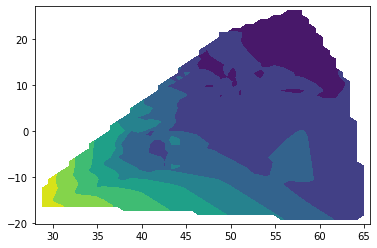

In [21]:
db1 = pd.DataFrame(index = stations.index)
db1['phi_'] = phi
db1['labda'] = labda
db2 = evap.merge(stations, left_index=True, right_on=stations.index).drop(['key_0'], axis = 1)
db2 = db2.merge(db1, left_index=True, right_on=stations.index).drop(['key_0'], axis = 1)

db3 = pd.DataFrame(index = stations.index)
db3['phi_'] = phi
db3['labda'] = labda
db4 = evap_th.merge(stations, left_index=True, right_on=stations.index).drop(['key_0'], axis = 1)
db4 = db2.merge(db3, left_index=True, right_on=stations.index).drop(['key_0'], axis = 1)
contour_data = db2.drop(columns = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Station Name', 'CN', 'Lat', 'Lon', 'h', 'phi'], axis = 1)
contour_data['jan'] = contour_data['Jan']
contour_data = contour_data.drop(['Jan'], axis = 1)
contour_data.columns = ['x', 'y', 'z']
from scipy.interpolate import griddata
x = contour_data.iloc[:,0].values
y = contour_data.iloc[:,1].values
z = contour_data.iloc[:,2].values

def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

X,Y,Z = plot_contour(x,y,z,resolution = 50, contour_method='linear')

# with plt.style.context("seaborn-white"):
#     fig, ax = plt.subplots(figsize=(13,8))
#     ax.scatter(x,y, color="black", linewidth=1, edgecolor="ivory", s=50)
#     ax.contourf(X,Y,Z)
plt.contourf(X,Y,Z);


## EXPORT THE EUROPE DATA

In [29]:
import pandas as pd
import numpy as np

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'mean']
months1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'sum']

stations = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\stations.txt", delimiter = ';', index_col = 0)
RH = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\RH.txt", delimiter = ';', index_col = 0, skiprows = 1, names = months)
T = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\T.txt", delimiter = ';', index_col = 0, skiprows = 1, names = months)
Tmax = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\Tmax.txt", delimiter = ';', index_col = 0, skiprows = 1, names = months)
Tmin = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\Tmin.txt", delimiter = ';', index_col = 0, skiprows = 1, names = months)
U = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\U.txt", delimiter = ';', index_col = 0, skiprows = 1, names = months)
RS = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\QQ.txt", delimiter = ';', index_col = 0, skiprows = 1, names = months)
P = pd.read_csv(r"C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\P.txt", delimiter = ';', index_col = 0, skiprows = 1, names = months1)

phi = np.zeros(len(stations['Lat']))
labda = np.zeros(len(stations['Lat']))

for i in range(len(stations)):
    phi[i] = (int(stations['Lat'].iloc[i][1:3]) + int(stations['Lat'].iloc[i][4:6])/60 + int(stations['Lat'].iloc[i][7:9])/3600)
    labda[i] = (int(stations['Lon'].iloc[i][1:4]) + int(stations['Lon'].iloc[i][5:7])/60 + int(stations['Lon'].iloc[i][8:10])/3600)
    if not stations['Lat'].iloc[i][0:1] == '+':
        phi[i] = - phi[i]
    if not stations['Lon'].iloc[i][0:1] == '+':
        labda[i] = - labda[i]

stations['Phi'] = phi
stations['Lamda'] = labda

drop = ['Station Name', 'CN', 'Lat', 'Lon', 'h', 'phi', 'Phi', 'Lamda']

RH['STATIONS']=RH.index
RH = pd.concat([stations, RH], axis = 1, join = 'inner').drop(drop, axis = 1)
RH_all = RH.melt(['STATIONS']).sort_values(['STATIONS']).set_index('STATIONS')
RH_all = RH_all.sort_values(by = ['STATIONS', 'variable'], ascending = [True, True])

T['STATIONS'] = T.index
T = pd.concat([stations, T], axis = 1, join = 'inner').drop(drop, axis = 1)
T_all = T.melt(['STATIONS']).sort_values(['STATIONS']).set_index('STATIONS')
T_all = T_all.sort_values(by = ['STATIONS', 'variable'], ascending = [True, True])

Tmax['STATIONS'] = Tmax.index
Tmax = pd.concat([stations, Tmax], axis = 1, join = 'inner').drop(drop, axis = 1)
Tmax_all = Tmax.melt(['STATIONS']).sort_values(['STATIONS']).set_index('STATIONS')
Tmax_all = Tmax_all.sort_values(by = ['STATIONS', 'variable'], ascending = [True, True])

Tmin['STATIONS'] = Tmin.index
Tmin = pd.concat([stations, Tmin], axis = 1, join = 'inner').drop(drop, axis = 1)
Tmin_all = Tmin.melt(['STATIONS']).sort_values(['STATIONS']).set_index('STATIONS')
Tmin_all = Tmin_all.sort_values(by = ['STATIONS', 'variable'], ascending = [True, True])

U['STATIONS'] = U.index
U = pd.concat([stations, U], axis = 1, join = 'inner').drop(drop, axis = 1)
U_all = U.melt(['STATIONS']).sort_values(['STATIONS']).set_index('STATIONS')
U_all = U_all.sort_values(by = ['STATIONS', 'variable'], ascending = [True, True])

RS['STATIONS'] = RS.index
RS = pd.concat([stations, RS], axis = 1, join = 'inner').drop(drop, axis = 1)
RS_all = RS.melt(['STATIONS']).sort_values(['STATIONS']).set_index('STATIONS')
RS_all = RS_all.sort_values(by = ['STATIONS', 'variable'], ascending = [True, True])

P['STATIONS'] = P.index
P = pd.concat([stations, P], axis = 1, join = 'inner').drop(drop, axis = 1)
P_all = P.melt(['STATIONS']).sort_values(['STATIONS']).set_index('STATIONS')
P_all = P_all.sort_values(by = ['STATIONS', 'variable'], ascending = [True, True])

data_all = [RS_all, Tmax_all, Tmin_all, T_all, RH_all, U_all]
europe = pd.DataFrame()
europe = pd.concat(data_all, axis = 1)

europe.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\europe.txt', sep=';', index=True, header=True)
P_all.to_csv(r'C:\Users\owner\Google Drive 2\MSc\TU DELFT - Water Managment\Additional Thesis\Results\validation ECA&D\P_all.txt', sep=';', index=True, header=True)